In [70]:
### Imports

import time

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 

import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import category_encoders as ce

In [71]:
### Settings

SEED = 21
TEST_SIZE = 0.33
EPOCHS = 10
BATCH_SIZE = 128


In [72]:
### Create dataframes

TEST_FEATURES_PATH = "/kaggle/input/lish-moa/test_features.csv"
TRAIN_FEATURES_PATH = "/kaggle/input/lish-moa/train_features.csv"
TRAIN_TARGETS_PATH = "/kaggle/input/lish-moa/train_targets_scored.csv"
TRAIN_TARGETS_NONSCORED_PATH = "/kaggle/input/lish-moa/train_targets_nonscored.csv"
SAMPLE_SUB_PATH = "/kaggle/input/lish-moa/sample_submission.csv"

test_features_df = pd.read_csv(TEST_FEATURES_PATH).sort_values(by='sig_id')
train_features_df = pd.read_csv(TRAIN_FEATURES_PATH).sort_values(by='sig_id')
train_targets_df = pd.read_csv(TRAIN_TARGETS_PATH).sort_values(by='sig_id')
train_targets_nonscored_df = pd.read_csv(TRAIN_TARGETS_NONSCORED_PATH)
sample_sub_df = pd.read_csv(SAMPLE_SUB_PATH).sort_values(by='sig_id')

In [73]:
# Encode training categorical features
enc = ce.BinaryEncoder(cols=['cp_type', 'cp_dose','cp_time']).fit(train_features_df)
train_features_enc_df = enc.transform(train_features_df).drop(columns=['sig_id'])


# Encode testing categorical features
enc = ce.BinaryEncoder(cols=['cp_type', 'cp_dose','cp_time']).fit(test_features_df)
test_features_enc_df = enc.transform(test_features_df).drop(columns=['sig_id'])

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [74]:
### Verify

train_features_enc_df.head()


,cp_type_0,cp_type_1,cp_time_0,cp_time_1,cp_time_2,cp_dose_0,cp_dose_1,g-0,g-1,g-2,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,1,0,0,1,0,1,1.0620,0.5577,-0.2479,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0,1,0,1,0,0,1,0.0743,0.4087,0.2991,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,0,1,0,1,1,0,1,0.6280,0.5817,1.5540,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,0,1,0,1,1,0,1,-0.5138,-0.2491,-0.2656,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,0,1,0,1,0,1,0,-0.3254,-0.4009,0.9700,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [75]:
### check how many 1's are in each class

value_counts_arr = np.sort([train_targets_df[col].value_counts()[1] for col in train_targets_df.columns])

print(value_counts_arr)

print(pd.Series(value_counts_arr).describe())

[  1   1   1   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   7   7   7   7  12  12  12  12  12  12  12  12  12  12  12  13  13
  17  18  18  18  18  18  18  18  18  18  18  18  18  18  19  19  19  19
  23  23  24  24  24  24  24  25  25  25  25  25  25  25  25  26  26  26
  29  30  30  30  30  30  30  31  31  31  31  32  35  36  36  36  36  36
  36  36  36  36  36  36  36  37  37  37  37  37  37  38  39  42  42  42
  42  43  44  47  48  48  48  48  48  48  48  49  50  51  54  54  54  55
  55  56  56  59  60  60  60  61  61  61  62  62  66  67  67  68  71  72
  72  72  73  73  73  73  73  74  74  80  80  84  85  89  89  92  93  96
  96  96  97  98 102 103 104 106 106 115 115 119 121 127 130 151 158 165
 170 190 192 223 236 241 264 266 267 270 273 279 281 283 297 301 316 336
 340 360 367 402 404 424 435 726 832]
count    207.000000
mean      81.376812
std      115.017572
min        1.000000
25%       19.000000
50%       38.000000
75%       82.000000
max      832.000000

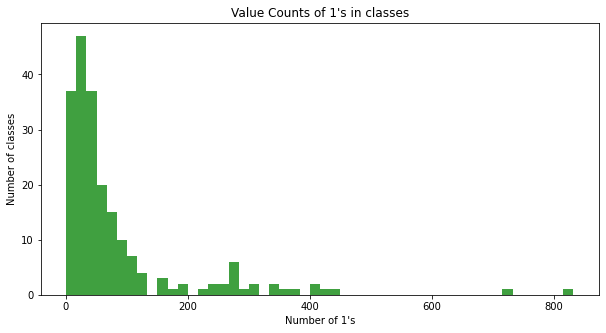

In [76]:
### Plot histogram of 1s counts in classes 

matplotlib.rcParams['figure.figsize'] = [10, 5]

plt.hist(value_counts_arr, 50, facecolor='g', alpha=0.75)
plt.xlabel('Number of 1\'s')
plt.ylabel('Number of classes')
plt.title('Value Counts of 1\'s in classes')
plt.show()

In [77]:
### Split training data into train/valid

x_train,x_valid,y_train,y_valid = train_test_split(train_features_enc_df,train_targets_df.drop(columns=['sig_id']),test_size=TEST_SIZE, random_state=SEED)


temp = 0

for col in y_train.columns:
    if len(np.unique(y_train[col])) == 1:
        print('Class {} only contains zeros'.format(col))
        temp = 1

if temp == 0:
    print('No classes have all zeros!')

No classes have all zeros!


In [78]:
### Verify
x_train.head()

,cp_type_0,cp_type_1,cp_time_0,cp_time_1,cp_time_2,cp_dose_0,cp_dose_1,g-0,g-1,g-2,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
16532,1,0,0,1,0,0,1,1.0510,-0.6319,-0.3564,...,0.2128,0.3130,0.0629,-0.9544,-0.3254,0.7104,0.1161,-0.6445,0.2287,-0.2091
14272,0,1,0,1,0,1,0,0.1481,-0.5605,0.3866,...,0.2127,-1.2510,0.7155,-0.4502,-0.4695,-0.1401,-0.1135,-0.4783,-0.1852,-0.6711
5491,0,1,0,1,0,0,1,-1.1170,-0.6044,-0.4348,...,0.4288,0.5469,0.2472,0.1102,-0.0422,-0.4896,-1.1250,0.8392,0.0776,-0.3560
4567,0,1,0,1,0,1,0,0.2343,-0.7714,0.1511,...,-0.6838,-0.4189,-0.4152,-0.3811,0.4572,0.4923,-0.2245,-0.1298,-0.3728,-0.6815
4889,0,1,0,0,1,0,1,-0.8858,-0.6730,0.0116,...,1.2980,0.3778,0.6573,0.7211,-0.0763,1.3730,0.1832,-0.3524,0.1080,-0.1521


In [79]:
def get_tf_model():
    model = tf.keras.Sequential([
        L.Flatten(input_shape=(1,879)),
        L.Dense(2000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(1000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(1000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(206, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

In [80]:
### Make Predictions

def get_preds(model,final=False):

    if 'tensorflow' in str(type(model)):
        if final==True:
            preds = np.array(model.predict(test_features_enc_df).astype("float64"))
        else:
            preds = np.array(model.predict(x_valid).astype("float64"))
    else:
        if final==True:
            preds = np.array(model.predict_proba(test_features_enc_df))
        else:
            preds = np.array(model.predict_proba(x_valid))
        
        preds = preds[:,:,1].T
    
    return preds

In [81]:
### Calculate validation score

def calc_loss(vals,preds):

    score = log_loss(np.ravel(vals),np.ravel(preds)) 

    print('Validation log loss score: {}'.format(score))
def run_model(model):

    ### fit the model
    fit_model(model)

    print('Getting validation predictions...')
    
    ### get the predictions
    temp_val_preds = get_preds(model,final=False)
    
    ### calculate log loss
    calc_loss(y_valid,temp_val_preds)

    val_preds.append(temp_val_preds)
    
    print('Calculating final predictions...')

    ### final preds
    final_preds.append(get_preds(model,final=True))
    
    print('Done')

In [82]:
val_preds = []
final_preds = []


In [83]:
run_model(model_2) 

Beginning to fit  <class 'tensorflow.python.keras.engine.sequential.Sequential'>
Epoch 1/10
125/125 [==============================] - 13s 101ms/step - loss: 0.0161 - accuracy: 0.1307 - val_loss: 0.0159 - val_accuracy: 0.1158
Epoch 2/10
125/125 [==============================] - 9s 72ms/step - loss: 0.0155 - accuracy: 0.1446 - val_loss: 0.0157 - val_accuracy: 0.1485
Epoch 3/10
125/125 [==============================] - 9s 74ms/step - loss: 0.0151 - accuracy: 0.1562 - val_loss: 0.0157 - val_accuracy: 0.1197
Epoch 4/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0143 - accuracy: 0.1658 - val_loss: 0.0159 - val_accuracy: 0.1187
Epoch 5/10
125/125 [==============================] - 9s 69ms/step - loss: 0.0138 - accuracy: 0.1791 - val_loss: 0.0156 - val_accuracy: 0.1233
Epoch 6/10
125/125 [==============================] - 9s 71ms/step - loss: 0.0132 - accuracy: 0.2016 - val_loss: 0.0158 - val_accuracy: 0.1279
Epoch 7/10
125/125 [==============================] - 9s 70

In [84]:
### Ensemble validation predictions

print('Ensembling validation predictions')
val_preds_avg = np.mean(np.array(val_preds),axis=0)

print('Ensembling final predictions')
final_predictions = np.mean(np.array(final_preds),axis=0)

Ensembling validation predictions
Ensembling final predictions


In [85]:
### Calculate ensemble validaiton loss

print('Calculating ensemble validation loss...')

calc_loss(y_valid,val_preds_avg)

Calculating ensemble validation loss...
Validation log loss score: 0.01691804090690797


In [86]:
### Insight into validation predictions

print(np.min(val_preds_avg))
print(np.max(val_preds_avg))
print(pd.DataFrame(val_preds_avg).describe())

2.0812303805461224e-31
1.0
                0             1             2             3             4    \
count  7.859000e+03  7.859000e+03  7.859000e+03  7.859000e+03  7.859000e+03   
mean   4.760536e-04  3.436901e-04  1.012242e-03  3.471435e-03  6.731886e-03   
std    1.116169e-03  6.692053e-04  1.161711e-03  1.207998e-02  2.038691e-02   
min    1.217297e-21  3.005029e-17  8.598053e-21  1.591068e-14  1.075696e-14   
25%    4.903723e-05  3.003962e-05  2.715141e-04  1.551360e-04  1.875460e-04   
50%    1.736879e-04  1.360476e-04  6.359816e-04  6.479621e-04  1.063555e-03   
75%    4.797131e-04  3.822595e-04  1.325428e-03  2.445489e-03  4.762292e-03   
max    2.898359e-02  1.365128e-02  1.416847e-02  4.089799e-01  5.086467e-01   

                5             6             7             8             9    \
count  7.859000e+03  7.859000e+03  7.859000e+03  7.859000e+03  7.859000e+03   
mean   1.776980e-03  1.677838e-03  2.876456e-03  1.789901e-04  3.674132e-03   
std    3.153071e-03  4.2

In [87]:
### Output final predictions

sample_sub_df.iloc[:,1:] = final_predictions
sample_sub_df.to_csv('submission.csv',index=False)


In [88]:
### Insight into final predictions

sample_sub_df.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,...,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03
mean,5.018097e-04,3.576555e-04,1.039613e-03,3.744616e-03,7.482985e-03,1.818805e-03,1.842716e-03,2.805617e-03,1.902148e-04,4.374351e-03,...,1.726395e-04,1.269920e-03,1.628212e-03,1.271978e-02,2.524127e-03,2.456178e-04,4.071003e-03,6.645974e-04,1.976422e-03,9.183822e-04
std,1.051692e-03,6.384903e-04,1.213173e-03,1.234916e-02,2.320339e-02,3.061272e-03,4.858713e-03,5.601455e-03,8.828740e-04,2.699795e-02,...,1.868005e-04,6.819199e-03,2.872513e-03,1.030961e-01,1.067216e-02,2.825965e-04,3.756443e-02,7.364884e-04,2.338818e-02,1.524512e-03
min,3.815770e-21,9.808111e-17,2.639259e-20,4.360198e-14,3.484092e-14,1.318523e-15,7.498876e-19,6.108938e-16,4.245354e-12,4.197467e-14,...,1.898741e-20,4.070934e-17,2.498414e-17,1.382525e-11,6.259822e-16,7.452411e-22,9.716953e-23,3.861492e-18,2.527403e-16,4.820999e-18
25%,5.739715e-05,3.524015e-05,2.702624e-04,1.586676e-04,2.260506e-04,2.473146e-04,1.422390e-04,3.007203e-04,1.399797e-05,9.564670e-05,...,4.709908e-05,6.636701e-05,2.443567e-04,1.746435e-05,1.101840e-04,5.917291e-05,2.354216e-05,2.100840e-04,5.101303e-05,1.705512e-04
50%,2.007931e-04,1.437962e-04,6.554723e-04,6.898493e-04,1.219481e-03,8.457154e-04,5.243570e-04,1.218379e-03,4.640054e-05,4.211515e-04,...,1.231132e-04,2.467632e-04,7.198900e-04,7.062201e-05,4.127175e-04,1.672208e-04,1.097100e-04,4.780293e-04,2.477765e-04,4.559457e-04
75%,5.233064e-04,4.201680e-04,1.353055e-03,2.692692e-03,5.206846e-03,2.078705e-03,1.601398e-03,3.212333e-03,1.376271e-04,1.767769e-03,...,2.357587e-04,8.023307e-04,1.820639e-03,2.999678e-04,1.379214e-03,3.319457e-04,5.443394e-04,8.638948e-04,8.887947e-04,1.052059e-03
max,1.776883e-02,1.234487e-02,1.361996e-02,2.496358e-01,4.639568e-01,8.142373e-02,1.360285e-01,1.764491e-01,2.896479e-02,8.380942e-01,...,1.927853e-03,2.978964e-01,5.269942e-02,9.997497e-01,2.124372e-01,3.217161e-03,9.919888e-01,1.029816e-02,9.383497e-01,2.283168e-02
